# Tatari Homework Assignment - Measuring Performance of TV Advertising

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas_profiling as pp
import datetime as dt
from datetime import datetime, time, timedelta
import pandasql as ps

# 1. Read Spot Data

In [2]:
# read spot_data
spot_data = pd.read_csv("assignment-analyst-1-spot-data.csv",parse_dates=True)
# see how the data looks
spot_data.head(3)

,id,time,creative_id,spend,program,duration,network_code,is_dual_feed,rotation,rotation_days,rotation_start,rotation_end,feed
0,411630,2017-10-16 05:25:32-07:00,f3483f810d44cef79d90a66ab2da1bf0,69.7,RAISING HOPE,14.0,FXX,True,Weekday Day,"{1,2,3,4,5}",7:00:00,15:00:00,1
1,411630,2017-10-16 08:25:32-07:00,f3483f810d44cef79d90a66ab2da1bf0,15.3,RAISING HOPE,14.0,FXX,True,Weekday Day,"{1,2,3,4,5}",7:00:00,15:00:00,2
2,411631,2017-10-16 05:56:36-07:00,eff6a8d032a8ca3ae098381569a9c15f,69.7,RAISING HOPE,14.0,FXX,True,Weekday Day,"{1,2,3,4,5}",7:00:00,15:00:00,1


## 1.1 Preparing the data

In [3]:
# column manipulation

# since feed 1 corresponds to the East Coast. The spot air timings for them lag by 3 hours. 
# adding those 3 hours to all rows associated to feed 1

# converting string fields to datetime fields

spot_data['timezone'] = spot_data['time'].str[-6:]
spot_data['timestamp'] = spot_data['time'].str[:-6]
spot_data['timestamp'] = pd.to_datetime(spot_data['timestamp'])
spot_data['new_timestamp'] = np.where(spot_data['feed'] == 1,
                                      spot_data['timestamp'] + pd.Timedelta(hours=3),
                                      spot_data['timestamp'])

spot_data['date'] = spot_data['time'].str[:10]
spot_data['date'] = spot_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
spot_data['new_date'] = spot_data['new_timestamp'].dt.date

spot_data['time'] = spot_data['time'].str[11:-6]
spot_data['time'] = spot_data['time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
spot_data['new_time'] = np.where(spot_data['feed'] == 1, 
                                 spot_data['time'].apply(lambda x: (dt.datetime.combine(dt.datetime(1,1,1), x,) + 
                                                                    dt.timedelta(hours=3,minutes=0)).time()),
                                 spot_data['time'])

spot_data['rotation_start'] = spot_data['rotation_start'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
spot_data['rotation_end'] = spot_data['rotation_end'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())

# get the important columns
imps=['id','timestamp','new_timestamp','date','new_date','time','new_time',
      'timezone','creative_id','spend','program','duration','network_code',
      'is_dual_feed','rotation','rotation_days','rotation_start','rotation_end','feed']
spot_data = spot_data[imps]

# Export the data in excel
# spot_data.to_csv('spot_data.csv',index=False)

# see how the data looks
spot_data.head()

,id,timestamp,new_timestamp,date,new_date,time,new_time,timezone,creative_id,spend,program,duration,network_code,is_dual_feed,rotation,rotation_days,rotation_start,rotation_end,feed
0,411630,2017-10-16 05:25:32,2017-10-16 08:25:32,2017-10-16,2017-10-16,05:25:32,08:25:32,-07:00,f3483f810d44cef79d90a66ab2da1bf0,69.7,RAISING HOPE,14.0,FXX,True,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,1
1,411630,2017-10-16 08:25:32,2017-10-16 08:25:32,2017-10-16,2017-10-16,08:25:32,08:25:32,-07:00,f3483f810d44cef79d90a66ab2da1bf0,15.3,RAISING HOPE,14.0,FXX,True,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,2
2,411631,2017-10-16 05:56:36,2017-10-16 08:56:36,2017-10-16,2017-10-16,05:56:36,08:56:36,-07:00,eff6a8d032a8ca3ae098381569a9c15f,69.7,RAISING HOPE,14.0,FXX,True,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,1
3,411631,2017-10-16 08:56:36,2017-10-16 08:56:36,2017-10-16,2017-10-16,08:56:36,08:56:36,-07:00,eff6a8d032a8ca3ae098381569a9c15f,15.3,RAISING HOPE,14.0,FXX,True,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,2
4,411651,2017-10-16 07:38:41,2017-10-16 10:38:41,2017-10-16,2017-10-16,07:38:41,10:38:41,-07:00,5992d996de2f11faa3492960a58de350,69.7,PARKS AND RECREATION,14.0,FXX,True,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,1


In [4]:
spot_data.describe(include='all')

,id,timestamp,new_timestamp,date,new_date,time,new_time,timezone,creative_id,spend,program,duration,network_code,is_dual_feed,rotation,rotation_days,rotation_start,rotation_end,feed
count,1456.000000,1456,1456,1456,1456,1456,1456,1456,1456,1456.000000,1296,1172.000000,1456,1456,1456,1456,1456,1456,1456.000000
unique,NaN,1456,728,29,29,1445,726,2,8,NaN,128,NaN,21,1,18,5,16,10,NaN
top,NaN,2017-11-08 15:06:01,2017-11-02 22:03:55,2017-11-08,2017-11-11,11:40:38,22:48:32,-07:00,f3483f810d44cef79d90a66ab2da1bf0,NaN,NBA GAMETIME,NaN,NBAT,True,Everyday Prime,"{1,2,3,4,5,6,7}",19:00:00,00:00:00,NaN
freq,NaN,1,2,80,82,2,4,970,576,NaN,154,NaN,350,1456,464,810,330,402,NaN
first,NaN,2017-10-16 05:25:32,2017-10-16 08:25:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-11-13 02:53:28,2017-11-13 02:53:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,430257.093407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.702679,NaN,15.068259,NaN,NaN,NaN,NaN,NaN,NaN,1.500000
std,13448.714565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237.966319,NaN,4.115180,NaN,NaN,NaN,NaN,NaN,NaN,0.500172
min,411630.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.060000,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,421971.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.950000,NaN,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [5]:
# Drop the fields that have only one value in them
# In the spot_data table, the 'timezone' contains only one value of '+00'. Hence we drop this field.
spot_data.drop(columns='is_dual_feed',inplace=True)

# 2. Read Traffic Data

In [6]:
# read the traffic data
traffic_data = pd.read_csv("assignment-analyst-1-web-traffic-data.csv")
# see how the data looks
traffic_data.head()

,time,traffic_source,value
0,2017-10-17 07:05:00+00,email,1.0
1,2017-10-17 07:07:00+00,email,1.0
2,2017-10-17 07:16:00+00,email,1.0
3,2017-10-17 07:17:00+00,email,1.0
4,2017-10-17 07:25:00+00,email,1.0


## 2.1 Preparing the data

In [7]:
# column manipulations
traffic_data['date'] = traffic_data['time'].str[:10]
traffic_data['timezone'] = traffic_data['time'].str[-3:]
traffic_data['timestamp'] = traffic_data['time'].str[:-3]
traffic_data['time'] = traffic_data['time'].str[11:-3]

# convert date and time fields to datetime objects
traffic_data['date'] = traffic_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
traffic_data['time'] = traffic_data['time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
traffic_data['timestamp'] = pd.to_datetime(traffic_data['timestamp'])

# 280 visit values are in decimal, rounding these up
traffic_data['value'] = np.ceil(traffic_data.value).astype(int)

# 6 visit values are negative, removing these
traffic_data = traffic_data[traffic_data.value >= 0]

# get the important columns
imps=['timestamp','date','time','timezone','traffic_source','value']
traffic_data = traffic_data[imps]

# # Export the data to excel
# traffic_data.to_csv('traffic_data.csv',index=False)

# see how the data looks
traffic_data.head()

,timestamp,date,time,timezone,traffic_source,value
0,2017-10-17 07:05:00,2017-10-17,07:05:00,+00,email,1
1,2017-10-17 07:07:00,2017-10-17,07:07:00,+00,email,1
2,2017-10-17 07:16:00,2017-10-17,07:16:00,+00,email,1
3,2017-10-17 07:17:00,2017-10-17,07:17:00,+00,email,1
4,2017-10-17 07:25:00,2017-10-17,07:25:00,+00,email,1


In [8]:
traffic_data.describe(include='all')

,timestamp,date,time,timezone,traffic_source,value
count,63951,63951,63951,63951,63951,63951.000000
unique,40380,29,1440,1,2,NaN
top,2017-10-21 00:59:00,2017-11-12,18:25:00,+00,direct,NaN
freq,2,2505,55,63951,40380,NaN
first,2017-10-16 07:00:00,NaN,NaN,NaN,NaN,NaN
last,2017-11-13 07:59:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,8.796219
std,NaN,NaN,NaN,NaN,NaN,19.581390
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,2.000000


In [9]:
# Drop the fields that have only one value in them
# In the traffic_data table, the 'is_dual_feed' contains only one value of 'TRUE'. Hence we drop this field.
traffic_data.drop(columns='timezone',inplace=True)

# 3. Exploratory Data Analysis

In [10]:
# Range of Data for spots and Traffic
print("Range for Spot airing:",spot_data.date.nunique(),
      "days ranging from", spot_data.date.min(),'to',spot_data.date.max())
print("Range for Traffic data:",traffic_data.date.nunique(),
      "days ranging from", traffic_data.date.min(),'to',traffic_data.date.max())

Range for Spot airing: 29 days ranging from 2017-10-16 to 2017-11-13
Range for Traffic data: 29 days ranging from 2017-10-16 to 2017-11-13


In [11]:
# Total Number of Creatives Aired
print("Total unique Creatives Aired:",spot_data.creative_id.nunique())
print("Total unique Spots Aired:",spot_data.id.nunique())

Total unique Creatives Aired: 8
Total unique Spots Aired: 728


In [12]:
# The number of ads aired per creative for every coast.
creatives = spot_data.pivot_table(index=['creative_id','feed'],
                                  values='id',aggfunc=pd.Series.nunique, margins=True)
# see how the pivot looks
print(creatives)
print("\n>>>8 Unique creatives were aired equally on both the feeds of east and west coast.\n" 
      ">>>A total of 728 spots were aired on each feed")

                                        id
creative_id                      feed     
5992d996de2f11faa3492960a58de350 1      64
                                 2      64
6570d4e06efb97840eec4d9d46cde0bb 1      66
                                 2      66
6e69270e444e10a1ec9a2bdfbb739c05 1      63
                                 2      63
a45caf06263a742e1b7bff7b3bb10ddf 1      59
                                 2      59
b6cc05016845138a72f2fa2e4f1f1a56 1      62
                                 2      62
efc5636dd257db2a6cf7cff2569f7d59 1      59
                                 2      59
eff6a8d032a8ca3ae098381569a9c15f 1      67
                                 2      67
f3483f810d44cef79d90a66ab2da1bf0 1     288
                                 2     288
All                                    728

>>>8 Unique creatives were aired equally on both the feeds of east and west coast.
>>>A total of 728 spots were aired on each feed


In [13]:
# Split of spots per feed
print("The number of ads aired per",spot_data.groupby(['feed']).size())
print("\nThe number of ads aired for both feeds (coasts) are the same. \nMeaning the same ad is aired on both the coasts")

The number of ads aired per feed
1    728
2    728
dtype: int64

The number of ads aired for both feeds (coasts) are the same. 
Meaning the same ad is aired on both the coasts


## 3.1Ads per Day per feed (Every ad is aired on both coasts)

In [14]:
# pivot table
rotations = spot_data.pivot_table(index=['date'], 
                                  values=['id'],
                                  aggfunc=pd.Series.nunique).reset_index().sort_values('id',
                                                                                       ascending=False,).reset_index(drop=True)
# see how the pivot looks
rotations.head()

,date,id
0,2017-11-08,44
1,2017-11-12,43
2,2017-11-11,43
3,2017-11-01,37
4,2017-10-17,37


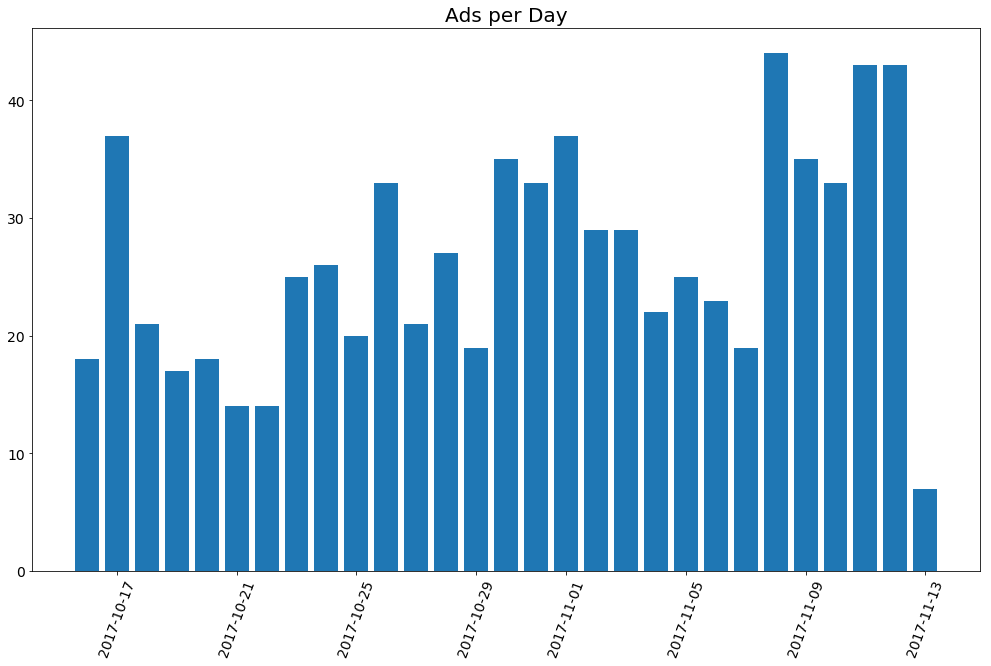

In [15]:
# plot the number of Ads per day
plt.figure(figsize=(17,10))
plt.bar(rotations.date,rotations.id)
# plt.legend(loc="upper left", fontsize='14')
plt.title('Ads per Day', fontsize='20')
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## 3.2 Ads per Rotation per feed (Every ad is aired on both coasts)

In [16]:
# pivot table
rotations = spot_data.pivot_table(index=['rotation'], 
                                  values=['id'],
                                  aggfunc=pd.Series.nunique).reset_index().sort_values('id',
                                                                                       ascending=False,).reset_index(drop=True)
# see how the pivot looks
rotations.head()

,rotation,id
0,Everyday Prime,232
1,Weekday Day,143
2,Everyday Early Fringe,64
3,Weekend,58
4,Everyday Day,53


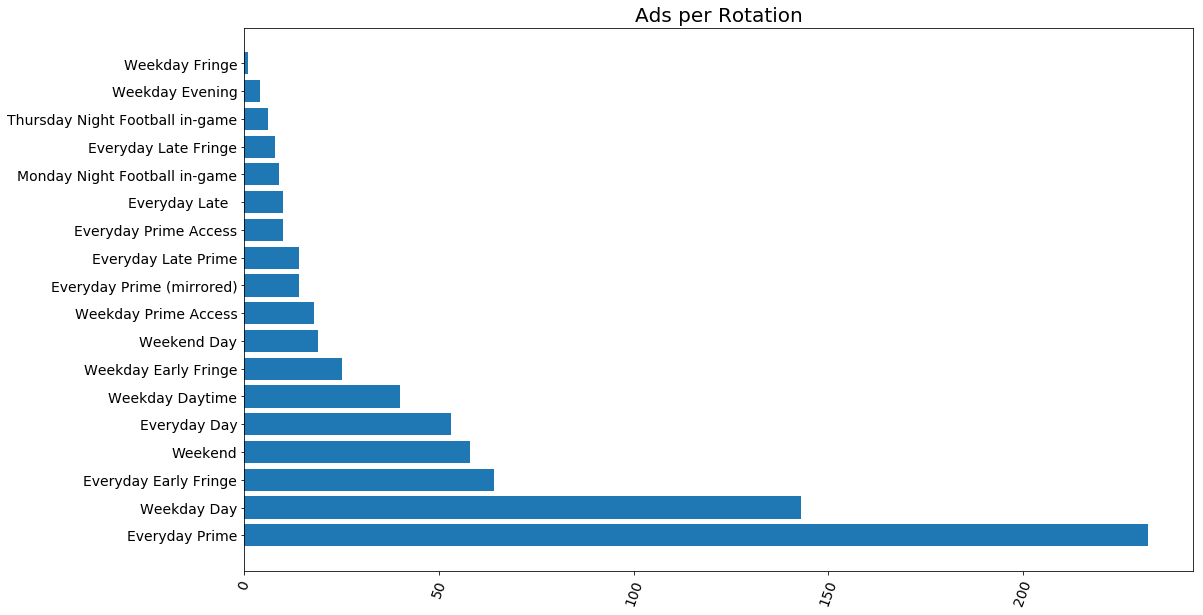

In [17]:
# plot the number of Ads per Rotation
plt.figure(figsize=(17,10))
plt.barh(rotations.rotation,rotations.id)
# plt.legend(loc="upper left", fontsize='14')
plt.title('Ads per Rotation', fontsize='20')
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## 3.3 Daily Visitors by email and direct visits

In [18]:
# pivot table
daily_traffic = traffic_data.pivot_table(index=['date'], columns='traffic_source',
                                         values='value',aggfunc='sum').reset_index()
# see how the pivot looks
daily_traffic.head()

traffic_source,date,direct,email
0,2017-10-16,6175,1093
1,2017-10-17,12134,4690
2,2017-10-18,9880,2015
3,2017-10-19,9726,1202
4,2017-10-20,9761,7131


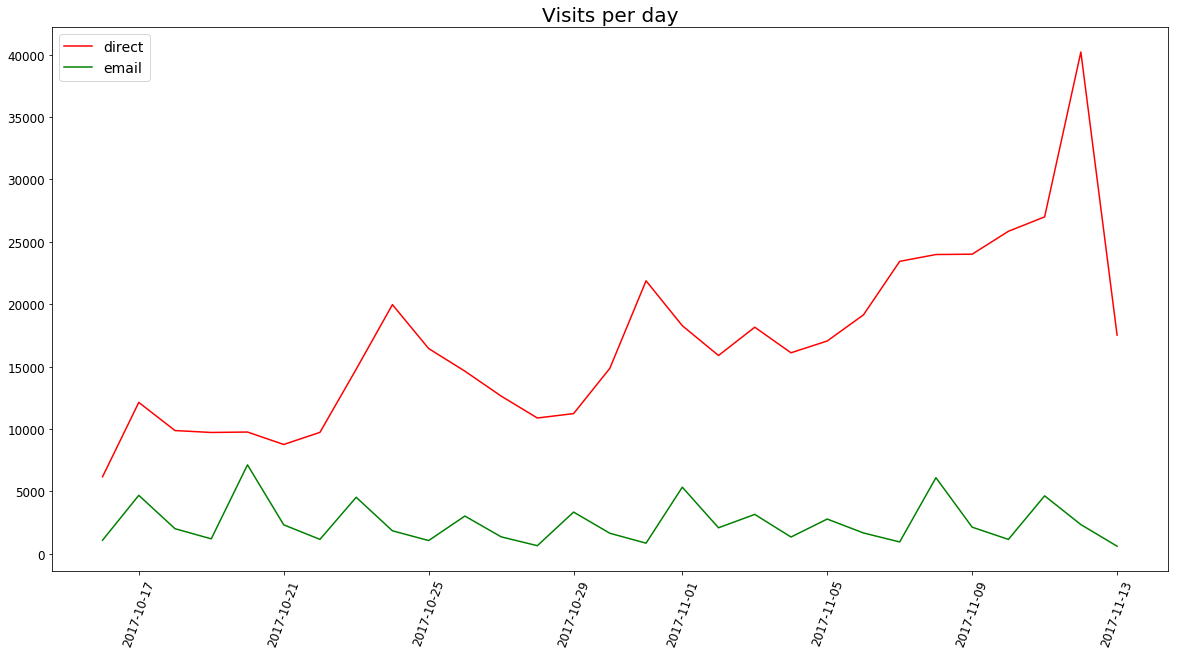

In [19]:
# plot the number of Visits per day
plt.figure(figsize=(20,10))
plt.plot(daily_traffic['date'], daily_traffic['direct'], color="red", label="direct")
plt.plot(daily_traffic['date'], daily_traffic['email'], color="green", label="email")
plt.legend(loc="upper left", fontsize='14')
plt.title('Visits per day', fontsize='20')
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 3.4 Network Analysis

In [20]:
# pivot table
spot_eda=spot_data.pivot_table(index=['network_code','program','date','feed','creative_id','id'],values=['spend'],
                               aggfunc={'spend':'sum'}).reset_index()
spot_eda.head(10)

,network_code,program,date,feed,creative_id,id,spend
0,COM,FUTURAMA,2017-11-10,1,f3483f810d44cef79d90a66ab2da1bf0,446814,209.1
1,COM,FUTURAMA,2017-11-10,1,f3483f810d44cef79d90a66ab2da1bf0,446828,209.1
2,COM,FUTURAMA,2017-11-10,2,f3483f810d44cef79d90a66ab2da1bf0,446814,45.9
3,COM,FUTURAMA,2017-11-10,2,f3483f810d44cef79d90a66ab2da1bf0,446828,45.9
4,COM,THAT '70S SHOW,2017-11-07,1,f3483f810d44cef79d90a66ab2da1bf0,437547,209.1
5,COM,THAT '70S SHOW,2017-11-07,1,f3483f810d44cef79d90a66ab2da1bf0,437548,209.1
6,COM,THAT '70S SHOW,2017-11-07,1,f3483f810d44cef79d90a66ab2da1bf0,437791,209.1
7,COM,THAT '70S SHOW,2017-11-07,1,f3483f810d44cef79d90a66ab2da1bf0,437792,209.1
8,COM,THAT '70S SHOW,2017-11-07,2,f3483f810d44cef79d90a66ab2da1bf0,437547,45.9
9,COM,THAT '70S SHOW,2017-11-07,2,f3483f810d44cef79d90a66ab2da1bf0,437548,45.9


In [21]:
ntwk=spot_eda.pivot_table(index=['network_code','feed'],
                          values=['spend','program','date','creative_id','id'],
                          aggfunc={'program':pd.Series.nunique,
                                   'date':pd.Series.nunique,
                                   'creative_id':pd.Series.nunique,
                                   'id':pd.Series.nunique,
                                   'spend':sum}).reset_index().rename(columns={"creative_id": "Creatives Aired", 
                                                                               "date": "Days Aired",
                                                                               "program":"Programs Aired",
                                                                               "id":"Total Spots",
                                                                               "spend":"Total Spend"}).set_index('network_code')

ntwk['Spend per Creative']=np.round(ntwk['Total Spend']/ntwk['Creatives Aired'],2)
ntwk['Spend per Day']=np.round(ntwk['Total Spend']/ntwk['Days Aired'],2)
ntwk['Spend per Spot']=np.round(ntwk['Total Spend']/ntwk['Total Spots'],2)
ntwk=ntwk.reset_index()
ntwk.head()
# Convert to Dollars
# apply(lambda x: "${:.3f}k".format((x/1000)))

,network_code,feed,Creatives Aired,Days Aired,Total Spots,Programs Aired,Total Spend,Spend per Creative,Spend per Day,Spend per Spot
0,COM,1,1,4,10,2,2091.00,2091.00,522.75,209.10
1,COM,2,1,4,10,2,459.00,459.00,114.75,45.90
2,DISH: ESPN,1,5,4,9,2,14114.25,2822.85,3528.56,1568.25
3,DISH: ESPN,2,5,4,9,2,3098.25,619.65,774.56,344.25
4,DISH: NFLN,1,5,2,6,1,2509.20,501.84,1254.60,418.20


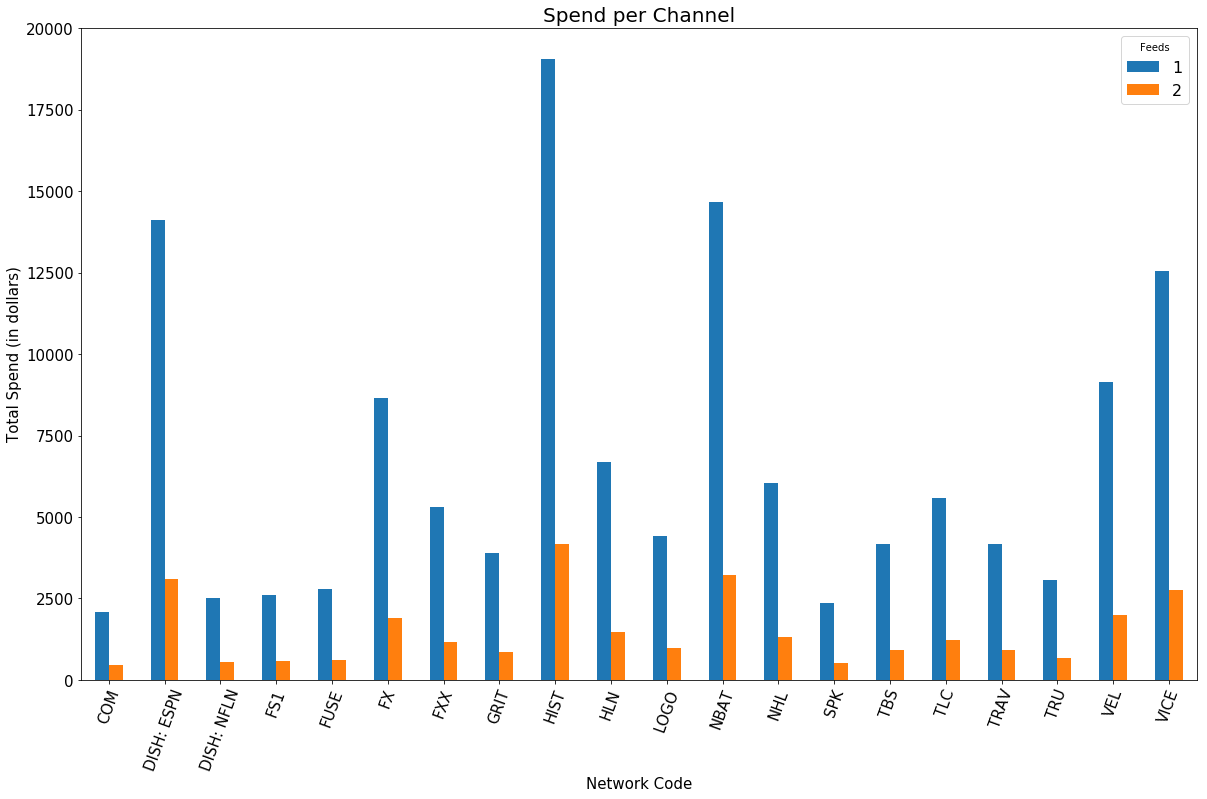

In [22]:
# plot the Total Spend per channel per feed
ntwk.pivot(index='network_code', columns='feed', values='Total Spend').plot(kind='bar',
                                                                            figsize=(20,12))
plt.title("Spend per Channel",fontsize=20)
plt.xlabel("Network Code", fontsize=15)
plt.xticks(rotation=70, fontsize=15)
plt.ylabel("Total Spend (in dollars)", fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',title='Feeds', fontsize=16)
plt.show()

## 3.5 Time of Week Analysis

In [23]:
# add time of week field
wks={'{1,2,3,4,5,6,7}':'Everyday',
     '{1,2,3,4,5}':'Weekday',
     '{6,7}':'Weekend',
     '{1}':"Monday",
     '{4}':"Thursday"}
nms={'rotation_days':'Time of Week',
     'id':'Spots Aired'}

spot_week=spot_data.pivot_table(index=['rotation_days','rotation'],
                                values='id',
                                aggfunc=pd.Series.nunique).reset_index().replace(wks).rename(columns=nms)
spot_week.head()

,Time of Week,rotation,Spots Aired
0,Everyday,Everyday Day,53
1,Everyday,Everyday Early Fringe,64
2,Everyday,Everyday Late,10
3,Everyday,Everyday Late Fringe,8
4,Everyday,Everyday Late Prime,14


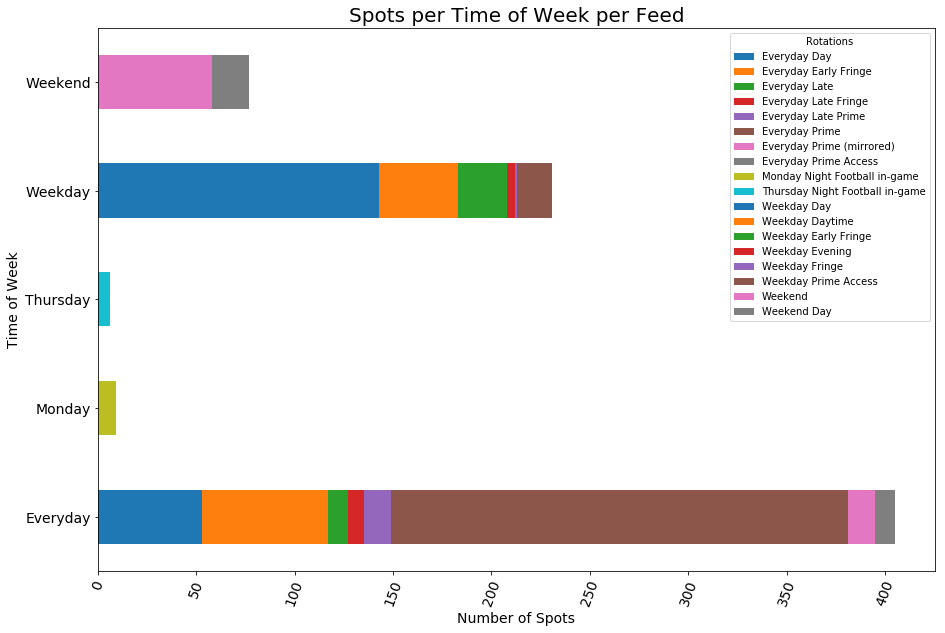

In [24]:
# plot spots aired per time of week per feed
spot_week.pivot(index='Time of Week', columns='rotation', values='Spots Aired').plot(kind='barh',
                                                                                 figsize=(15,10),
                                                                                 stacked=True)
plt.title("Spots per Time of Week per Feed",fontsize=20)
plt.xlabel("Number of Spots", fontsize=14)
plt.xticks(rotation=70, fontsize=14)
plt.ylabel("Time of Week", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best',title='Rotations', fontsize=10)
plt.show()

## Data Manipulations using SQL to calculate the Metrics -
    1. Daily Visitors
    2. Cost per Visit
    3. Incremental Visit Percentage

In [25]:
# function to run sql query
def pysqldf(q):
    '''
    The function takes an SQLite query as its argument and return the result. 
    The result can be later stored in a dataframe for further manipulation
    '''
    return ps.sqldf(q, globals())

In [26]:
# query execution
q1 = """
SELECT id, new_timestamp, new_date, new_time, timezone, creative_id, program, duration, 
       network_code, rotation, rotation_days, rotation_start, rotation_end,
       SUM(spend) as total_spend, COUNT(*) as no_of_ads, LEAD(new_timestamp,1) OVER (ORDER BY new_timestamp ASC) as next_timestamp
FROM spot_data
GROUP BY id, new_timestamp, new_date, new_time, timezone, creative_id, program, duration, 
         network_code, rotation, rotation_days, rotation_start, rotation_end
"""
q1=pysqldf(q1)

# datetime field manipulations
q1['new_timestamp'] = pd.to_datetime(q1['new_timestamp'])
q1['new_date'] = q1['new_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
q1['new_time'] = q1['new_time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.000000').time())
q1.next_timestamp.fillna(datetime(2020, 1, 1),inplace=True)
q1['next_timestamp'] = pd.to_datetime(q1['next_timestamp'])
q1.head()

,id,new_timestamp,new_date,new_time,timezone,creative_id,program,duration,network_code,rotation,rotation_days,rotation_start,rotation_end,total_spend,no_of_ads,next_timestamp
0,411630,2017-10-16 08:25:32,2017-10-16,08:25:32,-07:00,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00.000000,15:00:00.000000,85.0,2,2017-10-16 08:56:36
1,411631,2017-10-16 08:56:36,2017-10-16,08:56:36,-07:00,eff6a8d032a8ca3ae098381569a9c15f,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00.000000,15:00:00.000000,85.0,2,2017-10-16 10:38:41
2,411651,2017-10-16 10:38:41,2017-10-16,10:38:41,-07:00,5992d996de2f11faa3492960a58de350,PARKS AND RECREATION,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00.000000,15:00:00.000000,85.0,2,2017-10-16 10:38:57
3,411652,2017-10-16 10:38:57,2017-10-16,10:38:57,-07:00,f3483f810d44cef79d90a66ab2da1bf0,FANTOMWORKS,17.0,VEL,Weekday Day,"{1,2,3,4,5}",09:00:00.000000,16:00:00.000000,136.0,2,2017-10-16 12:49:41
4,411675,2017-10-16 12:49:41,2017-10-16,12:49:41,-07:00,b6cc05016845138a72f2fa2e4f1f1a56,PARKS AND RECREATION,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00.000000,15:00:00.000000,85.0,2,2017-10-16 14:05:14


In [27]:
# query execution
q2 = """
SELECT s.id, s.new_timestamp as spot_airing_time, s.creative_id, s.program, s.duration, s.network_code, s.rotation, 
       s.rotation_days, s.rotation_start, s.rotation_end, s.total_spend, s.no_of_ads, t.timestamp as traffic_time,
       t.traffic_source as source, t.value as visits
FROM q1 s
LEFT JOIN traffic_data t ON t.timestamp >= s.new_timestamp AND t.timestamp < s.next_timestamp
and t.traffic_source='direct'
"""
q2=pysqldf(q2)
q2.head()

,id,spot_airing_time,creative_id,program,duration,network_code,rotation,rotation_days,rotation_start,rotation_end,total_spend,no_of_ads,traffic_time,source,visits
0,411630,2017-10-16 08:25:32.000000,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00.000000,15:00:00.000000,85.0,2,2017-10-16 08:26:00.000000,direct,4.0
1,411630,2017-10-16 08:25:32.000000,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00.000000,15:00:00.000000,85.0,2,2017-10-16 08:27:00.000000,direct,1.0
2,411630,2017-10-16 08:25:32.000000,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00.000000,15:00:00.000000,85.0,2,2017-10-16 08:28:00.000000,direct,2.0
3,411630,2017-10-16 08:25:32.000000,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00.000000,15:00:00.000000,85.0,2,2017-10-16 08:29:00.000000,direct,3.0
4,411630,2017-10-16 08:25:32.000000,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00.000000,15:00:00.000000,85.0,2,2017-10-16 08:30:00.000000,direct,0.0


In [28]:
# datetime field manipulations
q2['spot_airing_time'] = pd.to_datetime(q2['spot_airing_time'])
q2['traffic_time'] = pd.to_datetime(q2['traffic_time'])
q2['rotation_start'] = q2['rotation_start'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.000000').time())
q2['rotation_end'] = q2['rotation_end'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.000000').time())
# q2.to_csv('q2.csv',index=False)
q2.head()

,id,spot_airing_time,creative_id,program,duration,network_code,rotation,rotation_days,rotation_start,rotation_end,total_spend,no_of_ads,traffic_time,source,visits
0,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:26:00,direct,4.0
1,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:27:00,direct,1.0
2,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:28:00,direct,2.0
3,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:29:00,direct,3.0
4,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:30:00,direct,0.0


In [29]:
# query execution
q3 = """
SELECT s.id, s.spot_airing_time, s.creative_id, s.program, s.duration, s.network_code, s.rotation, 
       s.rotation_days, s.rotation_start, s.rotation_end, s.total_spend, s.no_of_ads, s.source, 
       COUNT(s.traffic_time) as minutes, SUM(s.visits) as visits
FROM q2 s
GROUP BY s.id, s.spot_airing_time, s.creative_id, s.program, s.duration, s.network_code, s.rotation,
         s.rotation_days, s.rotation_start, s.rotation_end, s.total_spend, s.no_of_ads, s.source
"""
q3=pysqldf(q3)
# datetime field manipulations
q3['spot_airing_time'] = pd.to_datetime(q3['spot_airing_time'])
q3['rotation_start'] = q3['rotation_start'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.000000').time())
q3['rotation_end'] = q3['rotation_end'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.000000').time())
# q3.to_csv('q3.csv',index=False)
q3.head()

,id,spot_airing_time,creative_id,program,duration,network_code,rotation,rotation_days,rotation_start,rotation_end,total_spend,no_of_ads,source,minutes,visits
0,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,direct,31,29.0
1,411631,2017-10-16 08:56:36,eff6a8d032a8ca3ae098381569a9c15f,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,direct,102,119.0
2,411651,2017-10-16 10:38:41,5992d996de2f11faa3492960a58de350,PARKS AND RECREATION,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,None,0,NaN
3,411652,2017-10-16 10:38:57,f3483f810d44cef79d90a66ab2da1bf0,FANTOMWORKS,17.0,VEL,Weekday Day,"{1,2,3,4,5}",09:00:00,16:00:00,136.0,2,direct,131,356.0
4,411675,2017-10-16 12:49:41,b6cc05016845138a72f2fa2e4f1f1a56,PARKS AND RECREATION,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,direct,76,429.0


In [30]:
# datetime field manipulations
q3['spot_date'] = q3['spot_airing_time'].dt.date
q3['spot_hour'] = q3['spot_airing_time'].dt.hour
q3['rotation_weektime'] = q3['rotation_days'].replace({'{1,2,3,4,5}':'Weekday',
                                                       '{6,7}':'Weekend',
                                                       '{1}':'Weekday', 
                                                       '{4}':'Weekday',
                                                       '{1,2,3,4,5,6,7}':'Everyday'})

In [31]:
# get important columns
imps=['id', 'spot_airing_time', 'spot_date', 'spot_hour', 'creative_id', 
      'program', 'duration', 'network_code', 'rotation', 'rotation_days', 
      'rotation_weektime', 'rotation_start', 'rotation_end', 'total_spend', 
      'no_of_ads', 'source', 'minutes', 'visits']
q3=q3[imps]

In [32]:
q3.head()

,id,spot_airing_time,spot_date,spot_hour,creative_id,program,duration,network_code,rotation,rotation_days,rotation_weektime,rotation_start,rotation_end,total_spend,no_of_ads,source,minutes,visits
0,411630,2017-10-16 08:25:32,2017-10-16,8,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",Weekday,07:00:00,15:00:00,85.0,2,direct,31,29.0
1,411631,2017-10-16 08:56:36,2017-10-16,8,eff6a8d032a8ca3ae098381569a9c15f,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",Weekday,07:00:00,15:00:00,85.0,2,direct,102,119.0
2,411651,2017-10-16 10:38:41,2017-10-16,10,5992d996de2f11faa3492960a58de350,PARKS AND RECREATION,14.0,FXX,Weekday Day,"{1,2,3,4,5}",Weekday,07:00:00,15:00:00,85.0,2,None,0,NaN
3,411652,2017-10-16 10:38:57,2017-10-16,10,f3483f810d44cef79d90a66ab2da1bf0,FANTOMWORKS,17.0,VEL,Weekday Day,"{1,2,3,4,5}",Weekday,09:00:00,16:00:00,136.0,2,direct,131,356.0
4,411675,2017-10-16 12:49:41,2017-10-16,12,b6cc05016845138a72f2fa2e4f1f1a56,PARKS AND RECREATION,14.0,FXX,Weekday Day,"{1,2,3,4,5}",Weekday,07:00:00,15:00:00,85.0,2,direct,76,429.0


## 3.6 Visits vs CPV per Network

In [33]:
# pivot table
ntwk_cpv=q3.pivot_table(index='network_code',values=['total_spend','visits'], aggfunc={'total_spend':sum,
                                                                              'visits':sum}).reset_index()
# create new field for Cost per visit
ntwk_cpv['CPV']=ntwk_cpv['total_spend']/ntwk_cpv['visits']
ntwk_cpv.sort_values('visits', ascending=False, inplace=True)
ntwk_cpv.head()

,network_code,total_spend,visits,CPV
11,NBAT,17902.7,123288.0,0.145210
20,VICE,15317.0,111380.0,0.137520
10,LOGO,5397.5,47679.0,0.113205
12,NHL,7352.5,27582.0,0.266569
19,VEL,11152.0,26622.0,0.418902


C:\Users\Shubham\Miniconda3\lib\site-packages\matplotlib\legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


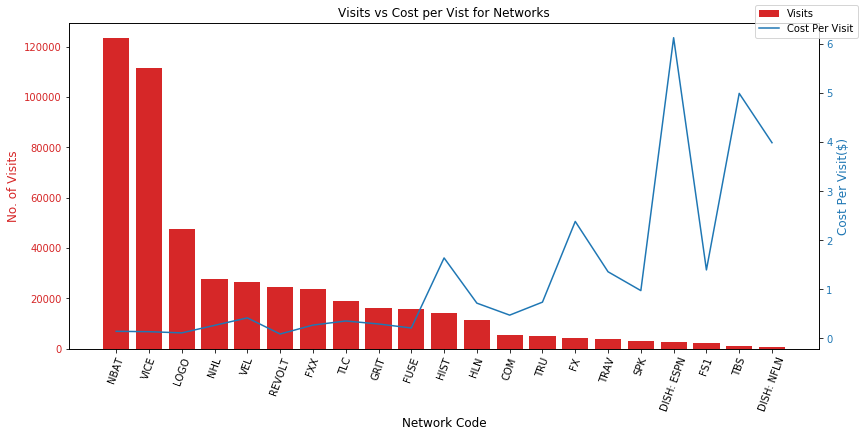

In [34]:
# Plot visit vs cpv for different networks
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Network Code', fontsize=12)
ax1.set_xticklabels(ntwk_cpv['network_code'], rotation=70)
ax1.set_ylabel('No. of Visits', color='tab:red', fontsize=12)
ax1.bar(ntwk_cpv['network_code'], ntwk_cpv['visits'], color='tab:red', label='Visits')
ax1.tick_params(axis='y', labelcolor='tab:red')

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

ax2.set_ylabel('Cost Per Visit($)', color='tab:blue', fontsize=12)
ax2.plot(ntwk_cpv['network_code'], ntwk_cpv['CPV'], color='tab:blue', label='Cost Per Visit')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# otherwise the right y-label is slightly clipped
fig.tight_layout()
fig.legend(loc="best")
plt.title('Visits vs Cost per Vist for Networks')
plt.show()

## 3.7 Visits vs CPV per Day

In [35]:
# pivot table
day_cpv=q3.pivot_table(index='spot_date',values=['total_spend','visits'], aggfunc={'total_spend':sum,
                                                                                   'visits':sum}).reset_index()
# create new field for Cost per visit
day_cpv['CPV']=day_cpv['total_spend']/day_cpv['visits']
# day_cpv.sort_values('visits', ascending=False, inplace=True)
day_cpv.head()

,spot_date,total_spend,visits,CPV
0,2017-10-16,4071.5,10268.0,0.396523
1,2017-10-17,3910.0,8340.0,0.468825
2,2017-10-18,3145.0,12534.0,0.250918
3,2017-10-19,2397.0,6969.0,0.343952
4,2017-10-20,2737.0,9627.0,0.284305


C:\Users\Shubham\Miniconda3\lib\site-packages\matplotlib\legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


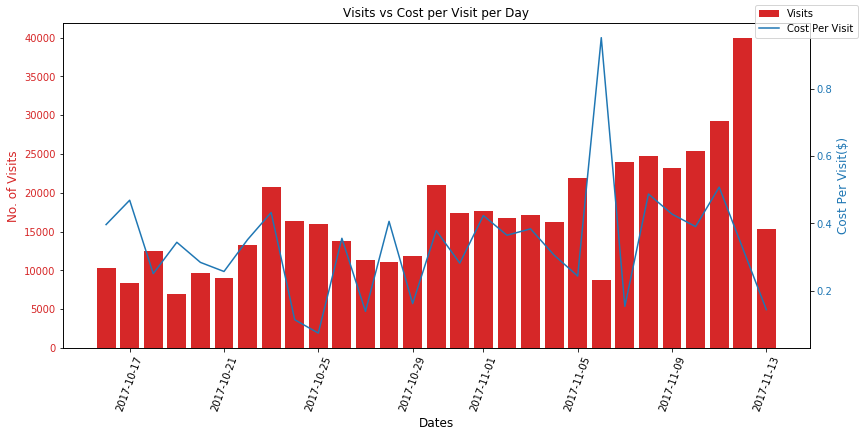

In [36]:
# plot for visit vs cpv per day
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Dates', fontsize=12)
ax1.set_xticklabels(day_cpv['spot_date'], rotation=70)
ax1.set_ylabel('No. of Visits', color='tab:red', fontsize=12)
ax1.bar(day_cpv['spot_date'], day_cpv['visits'], color='tab:red', label='Visits')
ax1.tick_params(axis='y', labelcolor='tab:red')

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

ax2.set_ylabel('Cost Per Visit($)', color='tab:blue', fontsize=12)
ax2.plot(day_cpv['spot_date'], day_cpv['CPV'], color='tab:blue', label='Cost Per Visit')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# otherwise the right y-label is slightly clipped
fig.tight_layout()
fig.legend(loc="best")
plt.title('Visits vs Cost per Visit per Day')
plt.show()

## 3.8 Visits vs CPV per Hour of Spot Airing

In [37]:
# pivot table
hrs_cpv=q3.pivot_table(index='spot_hour',values=['total_spend','visits'], aggfunc={'total_spend':sum,
                                                                                   'visits':sum}).reset_index()
# create new field for Cost per visit
hrs_cpv['CPV']=hrs_cpv['total_spend']/hrs_cpv['visits']
# day_cpv.sort_values('visits', ascending=False, inplace=True)
hrs_cpv.head()

,spot_hour,total_spend,visits,CPV
0,0,2316.25,14657.0,0.158030
1,1,2686.00,30526.0,0.087991
2,2,2962.25,49444.0,0.059911
3,6,531.25,2375.0,0.223684
4,7,488.75,497.0,0.983400


C:\Users\Shubham\Miniconda3\lib\site-packages\matplotlib\legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


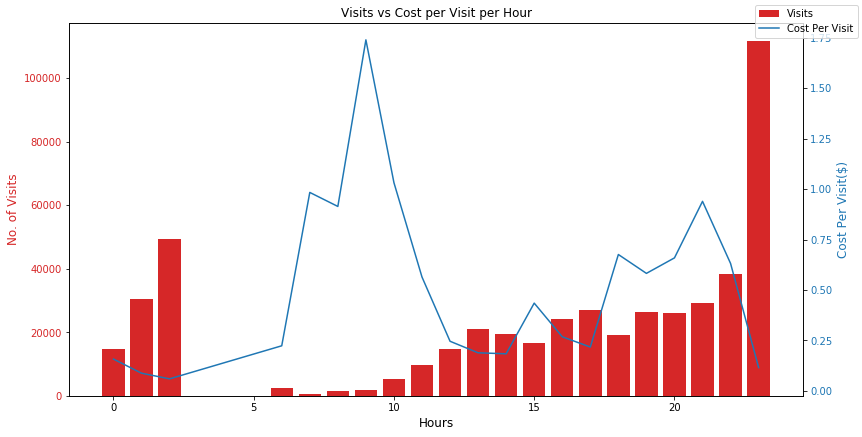

In [38]:
# plot visit vs cpv per hour of spot-airing
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Hours', fontsize=12)
# ax1.set_xticklabels(hrs_cpv['spot_hour'])
ax1.set_ylabel('No. of Visits', color='tab:red', fontsize=12)
ax1.bar(hrs_cpv['spot_hour'], hrs_cpv['visits'], color='tab:red', label='Visits')
ax1.tick_params(axis='y', labelcolor='tab:red')

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

ax2.set_ylabel('Cost Per Visit($)', color='tab:blue', fontsize=12)
ax2.plot(hrs_cpv['spot_hour'], hrs_cpv['CPV'], color='tab:blue', label='Cost Per Visit')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# otherwise the right y-label is slightly clipped
fig.tight_layout()
fig.legend(loc="best")
plt.title('Visits vs Cost per Visit per Hour')
plt.show()

## 3.9 Visits vs CPV per Spot Duration

In [39]:
# pivot table
dur_cpv=q3.pivot_table(index='duration',values=['total_spend','visits'], 
                       aggfunc={'total_spend':sum,'visits':sum}, dropna=False).reset_index()

# create new field for Cost per visit
dur_cpv['CPV']=dur_cpv['total_spend']/dur_cpv['visits']
# day_cpv.sort_values('visits', ascending=False, inplace=True)
dur_cpv

,duration,total_spend,visits,CPV
0,12.0,2465.00,4195.0,0.587604
1,13.0,15486.15,73983.0,0.209320
2,14.0,87822.00,293886.0,0.298830
3,15.0,2262.70,8983.0,0.251887
4,17.0,714.00,625.0,1.142400
5,27.0,595.00,873.0,0.681558
6,28.0,2788.00,652.0,4.276074
7,29.0,23583.25,51236.0,0.460287


C:\Users\Shubham\Miniconda3\lib\site-packages\matplotlib\legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


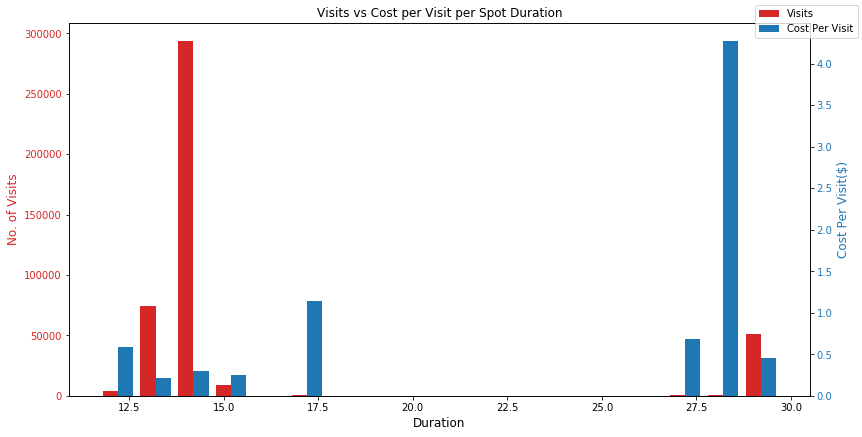

In [40]:
# plot visit vs cpv per spot duration
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Duration', fontsize=12)
# ax1.set_xticklabels(dur_cpv['duration'])
ax1.set_ylabel('No. of Visits', color='tab:red', fontsize=12)
ax1.bar(dur_cpv['duration'], dur_cpv['visits'], color='tab:red', label='Visits', width=0.4)
ax1.tick_params(axis='y', labelcolor='tab:red')

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

ax2.set_ylabel('Cost Per Visit($)', color='tab:blue', fontsize=12)
ax2.bar(dur_cpv['duration']+0.4, dur_cpv['CPV'], color='tab:blue', label='Cost Per Visit',  width=0.4)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# otherwise the right y-label is slightly clipped
fig.tight_layout()
fig.legend(loc="best")
plt.title('Visits vs Cost per Visit per Spot Duration')
plt.show()

## 3.9 Visits vs CPV per Creative

In [41]:
# pivot table
cre_cpv=q3.pivot_table(index='creative_id',values=['total_spend','visits'], 
                       aggfunc={'total_spend':sum,'visits':sum}, dropna=False).reset_index()

# create new field for Cost per visit
cre_cpv['CPV']=cre_cpv['total_spend']/cre_cpv['visits']
cre_cpv

,creative_id,total_spend,visits,CPV
0,5992d996de2f11faa3492960a58de350,11099.30,28790.0,0.385526
1,6570d4e06efb97840eec4d9d46cde0bb,12630.15,34769.0,0.363259
2,6e69270e444e10a1ec9a2bdfbb739c05,30706.25,62300.0,0.492877
3,a45caf06263a742e1b7bff7b3bb10ddf,9520.85,39392.0,0.241695
4,b6cc05016845138a72f2fa2e4f1f1a56,10897.85,44994.0,0.242207
5,efc5636dd257db2a6cf7cff2569f7d59,8749.90,27542.0,0.317693
6,eff6a8d032a8ca3ae098381569a9c15f,11391.70,40344.0,0.282364
7,f3483f810d44cef79d90a66ab2da1bf0,70555.10,211938.0,0.332904


C:\Users\Shubham\Miniconda3\lib\site-packages\matplotlib\legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


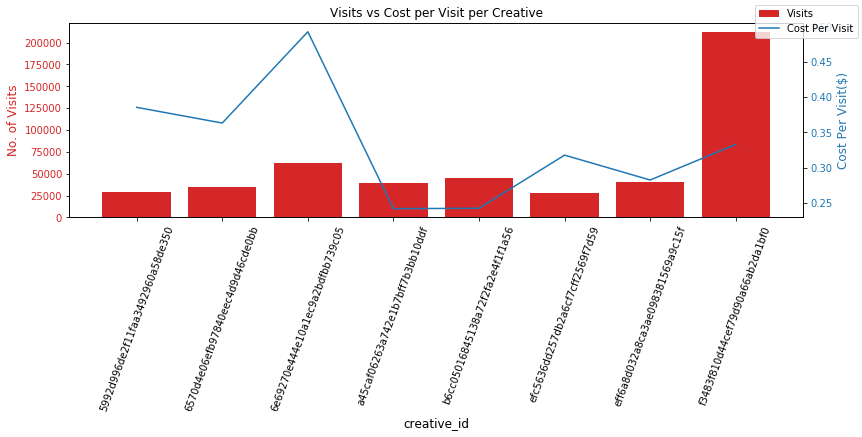

In [42]:
# plot visit vs cpv for different creative
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('creative_id', fontsize=12)
ax1.set_xticklabels(cre_cpv['creative_id'], rotation=70)
ax1.set_ylabel('No. of Visits', color='tab:red', fontsize=12)
ax1.bar(cre_cpv['creative_id'], cre_cpv['visits'], color='tab:red', label='Visits')
ax1.tick_params(axis='y', labelcolor='tab:red')

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

ax2.set_ylabel('Cost Per Visit($)', color='tab:blue', fontsize=12)
ax2.plot(cre_cpv['creative_id'], cre_cpv['CPV'], color='tab:blue', label='Cost Per Visit')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# otherwise the right y-label is slightly clipped
fig.tight_layout()
fig.legend(loc="best")
plt.title('Visits vs Cost per Visit per Creative')
plt.show()

# 4. TV ad - Direct and Brand Response

#### TV Advertisement and Incremental Responses:

    Household: 100% incremental till 4 min. then flat at 40%
    Insurance: 120% incremental till 3 min. Then 60% until 5 min and drop to 0% later
    Weight Loss: 400% at 2 min, 200% at 3 min, 100% at 4 min, 0% later
    Brokerage: 35% till 3 min, 10% till 6 min, then flat

#### Hence going forward, We will have two types of Responses:
    - Immediate Responses: Visits that happen within 6 minutes of spot airing on TV
    - Drag Responses: Visits that happen after 6 minutes of spot airing on TV

In [43]:
# create a copy of the dataframe to work upon
q=q2.copy()
q.head(5)

,id,spot_airing_time,creative_id,program,duration,network_code,rotation,rotation_days,rotation_start,rotation_end,total_spend,no_of_ads,traffic_time,source,visits
0,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:26:00,direct,4.0
1,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:27:00,direct,1.0
2,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:28:00,direct,2.0
3,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:29:00,direct,3.0
4,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:30:00,direct,0.0


In [44]:
# Calculate time difference between airing and traffic visit
q['response_time']=q['traffic_time']-q['spot_airing_time']
q['response_time']=q['response_time']/np.timedelta64(1,'m').astype(int)
q.head()

,id,spot_airing_time,creative_id,program,duration,network_code,rotation,rotation_days,rotation_start,rotation_end,total_spend,no_of_ads,traffic_time,source,visits,response_time
0,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:26:00,direct,4.0,00:00:28
1,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:27:00,direct,1.0,00:01:28
2,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:28:00,direct,2.0,00:02:28
3,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:29:00,direct,3.0,00:03:28
4,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:30:00,direct,0.0,00:04:28


In [45]:
# Function to check if visit is within 6 minutes of spot airing
def r_type(row):
    '''
    The function takes one row of a dataframe as input, checks whether response time 
    for that row is less than or equal 10 minutes. If less classifies the row as
    Immediate response, else Drag Response.
    '''
    if row['response_time'] <= timedelta(minutes=10):
        val = 'Immediate'
    else:
        val = 'Drag'
    return val

In [46]:
# Create new field based on the function using apply
q['response_type'] = q.apply(r_type, axis=1)
q.head()

,id,spot_airing_time,creative_id,program,duration,network_code,rotation,rotation_days,rotation_start,rotation_end,total_spend,no_of_ads,traffic_time,source,visits,response_time,response_type
0,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:26:00,direct,4.0,00:00:28,Immediate
1,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:27:00,direct,1.0,00:01:28,Immediate
2,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:28:00,direct,2.0,00:02:28,Immediate
3,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:29:00,direct,3.0,00:03:28,Immediate
4,411630,2017-10-16 08:25:32,f3483f810d44cef79d90a66ab2da1bf0,RAISING HOPE,14.0,FXX,Weekday Day,"{1,2,3,4,5}",07:00:00,15:00:00,85.0,2,2017-10-16 08:30:00,direct,0.0,00:04:28,Immediate


In [47]:
# date time field manipulations
q['spot_date'] = q['spot_airing_time'].dt.date
q['spot_hour'] = q['spot_airing_time'].dt.hour
q['rotation_weektime'] = q['rotation_days'].replace({'{1,2,3,4,5}':'Weekday',
                                                     '{6,7}':'Weekend',
                                                     '{1}':'Weekday', 
                                                     '{4}':'Weekday',
                                                     '{1,2,3,4,5,6,7}':'Everyday'})

# get important fields
imps=['id', 'spot_airing_time', 'spot_date', 'spot_hour', 'creative_id', 
      'program', 'duration', 'network_code', 'rotation', 'rotation_days', 
      'rotation_weektime', 'rotation_start', 'rotation_end', 'total_spend', 
      'no_of_ads', 'traffic_time', 'source', 'visits', 'response_time', 'response_type']
q=q[imps]

## 4.1 Incremental & Brand Response per day

In [48]:
# pivot table
resp=q.pivot_table(index='spot_date', values='visits', columns='response_type', aggfunc=sum).reset_index()
# create new field for drag_ratio
resp['drag_ratio']=resp['Immediate']/resp['Drag']
resp.head()

response_type,spot_date,Drag,Immediate,drag_ratio
0,2017-10-16,9099.0,1169.0,0.128476
1,2017-10-17,6308.0,2032.0,0.322131
2,2017-10-18,11272.0,1262.0,0.111959
3,2017-10-19,6224.0,745.0,0.119698
4,2017-10-20,8607.0,1020.0,0.118508


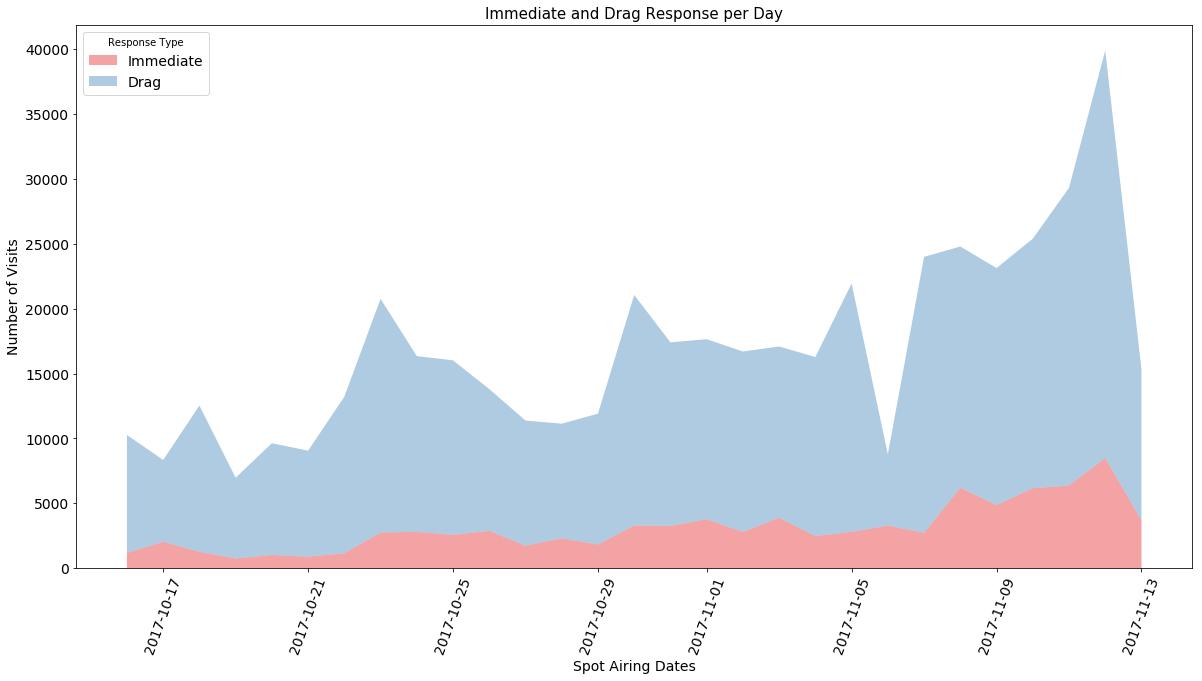

In [49]:
# plot Immediate and Drag response per day
# Your x and y axis
x=resp['spot_date']
y=[resp['Immediate'], resp['Drag']]
# z=resp['drag_ratio']

plt.figure(figsize=(20,10))
pal=sns.color_palette("Set1")
plt.stackplot(x,y, labels=['Immediate','Drag'], colors=pal, alpha=0.4)
plt.title("Immediate and Drag Response per Day",fontsize=15)
plt.xlabel("Spot Airing Dates", fontsize=14)
plt.xticks(rotation=70, fontsize=14)
plt.ylabel("Number of Visits", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=2,title='Response Type', fontsize=14)
plt.show()

# # use a known color palette (see..)
# fig, ax1 = plt.subplots(figsize=(12,6))

# pal=sns.color_palette("Set1")
# ax1.set_xlabel('Spot Airing Dates', fontsize=12)
# ax1.set_xticklabels(x, rotation=70)
# ax1.set_ylabel('No. of Visits', color='tab:red', fontsize=12)
# ax1.stackplot(x,y, labels=['Incremental','Drag'], colors=pal, alpha=0.4)
# ax1.tick_params(axis='y', labelcolor='tab:red')

# # instantiate a second axes that shares the same x-axis
# ax2 = ax1.twinx()

# ax2.set_ylabel('Drag Ratio', color='tab:blue', fontsize=12)
# ax2.plot(x, z, color='tab:blue', label='Drag Ratio')
# ax2.tick_params(axis='y', labelcolor='tab:blue')

# # otherwise the right y-label is slightly clipped
# fig.tight_layout()
# fig.legend(loc="best")
# plt.title("Incremental and Drag Response",fontsize=15)
# plt.show()

## 4.2 Average time between airings by Day

In [50]:
# create a new field for time difference (in minutes) based on the response_time field
q['time_diff'] = [td.total_seconds()/60 for td in q['response_time']]
# pivot table
airing = q.pivot_table(index='spot_date', values=['time_diff','visits'], aggfunc={'time_diff':np.mean,
                                                                                  'visits':sum}).reset_index()
# sort values
airing.sort_values('time_diff')

,spot_date,time_diff,visits
21,2017-11-06,20.895288,8774.0
1,2017-10-17,26.742832,8340.0
27,2017-11-12,49.874578,39905.0
26,2017-11-11,52.239621,29316.0
23,2017-11-08,88.478050,24791.0
3,2017-10-19,90.179809,6969.0
24,2017-11-09,98.913216,23131.0
14,2017-10-30,106.934236,21058.0
15,2017-10-31,110.703127,17403.0
0,2017-10-16,114.076358,10268.0


## 4.3 Incremental and Brand Response per Creative

In [51]:
# pivot table
resp=q.pivot_table(index='creative_id', values='visits', columns='response_type', aggfunc=sum).reset_index()
# create new field for drag_ratio
resp['drag_ratio']=resp['Immediate']/resp['Drag']
resp

response_type,creative_id,Drag,Immediate,drag_ratio
0,5992d996de2f11faa3492960a58de350,23627.0,5163.0,0.218521
1,6570d4e06efb97840eec4d9d46cde0bb,27643.0,7126.0,0.257787
2,6e69270e444e10a1ec9a2bdfbb739c05,49620.0,12680.0,0.255542
3,a45caf06263a742e1b7bff7b3bb10ddf,34027.0,5365.0,0.157669
4,b6cc05016845138a72f2fa2e4f1f1a56,39492.0,5502.0,0.139319
5,efc5636dd257db2a6cf7cff2569f7d59,21381.0,6161.0,0.288153
6,eff6a8d032a8ca3ae098381569a9c15f,34399.0,5945.0,0.172825
7,f3483f810d44cef79d90a66ab2da1bf0,170768.0,41170.0,0.241087


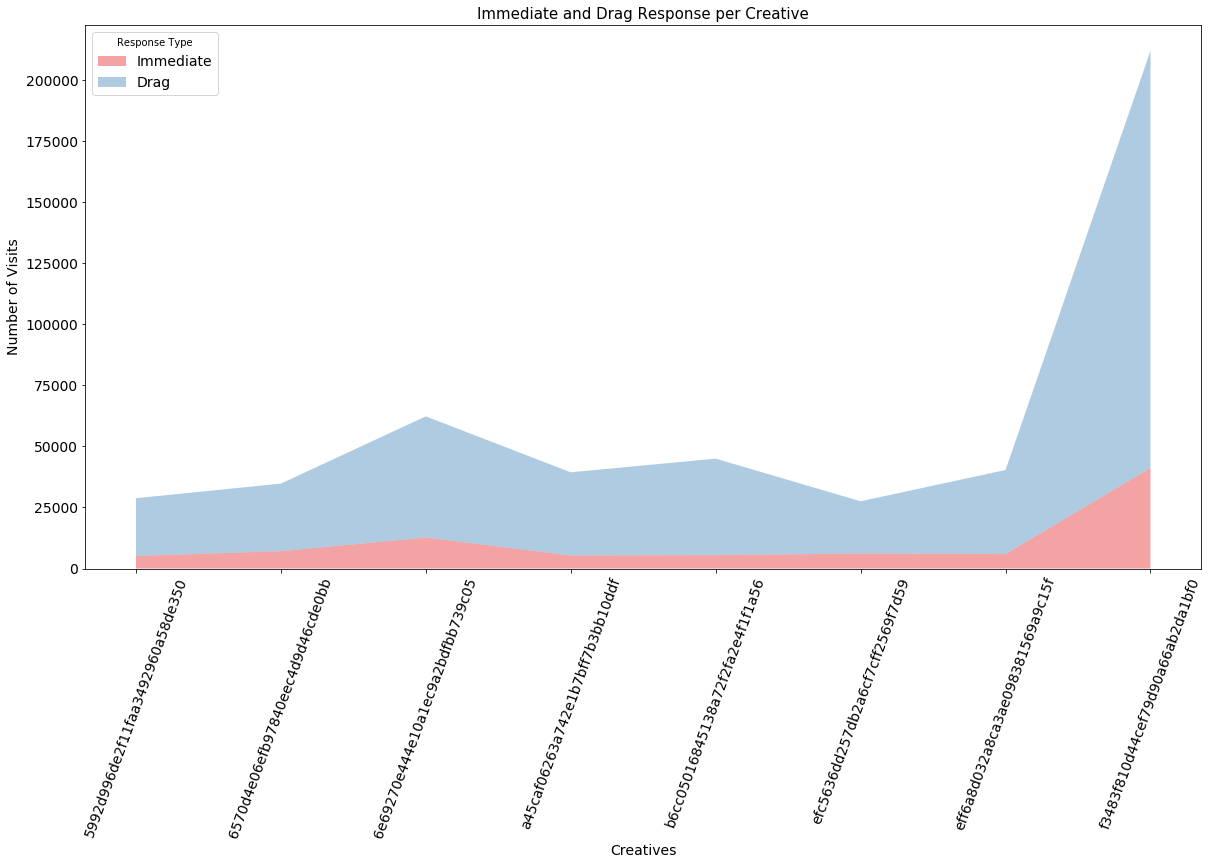

In [52]:
# plot of Immediate and Drag response per creative
# Your x and y axis
x=resp['creative_id']
y=[resp['Immediate'], resp['Drag']]
# z=resp['drag_ratio']

plt.figure(figsize=(20,10))
pal=sns.color_palette("Set1")
plt.stackplot(x,y, labels=['Immediate','Drag'], colors=pal, alpha=0.4)
plt.title("Immediate and Drag Response per Creative",fontsize=15)
plt.xlabel("Creatives", fontsize=14)
plt.xticks(rotation=70, fontsize=14)
plt.ylabel("Number of Visits", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=2,title='Response Type', fontsize=14)
plt.show()

# # use a known color palette (see..)
# fig, ax1 = plt.subplots(figsize=(12,6))

# pal=sns.color_palette("Set1")
# ax1.set_xlabel('Creatives', fontsize=12)
# ax1.set_xticklabels(x, rotation=70)
# ax1.set_ylabel('No. of Visits', color='tab:red', fontsize=12)
# ax1.stackplot(x,y, labels=['Incremental','Drag'], colors=pal, alpha=0.4)
# ax1.tick_params(axis='y', labelcolor='tab:red')

# # instantiate a second axes that shares the same x-axis
# ax2 = ax1.twinx()

# ax2.set_ylabel('Drag Ratio', color='tab:blue', fontsize=12)
# ax2.plot(x, z, color='tab:blue', label='Drag Ratio')
# ax2.tick_params(axis='y', labelcolor='tab:blue')

# # otherwise the right y-label is slightly clipped
# fig.tight_layout()
# fig.legend(loc="best")
# plt.title("Incremental and Drag Response",fontsize=15)
# plt.show()

## 4.4 Incremental Percentage Lift per hour

In [53]:
# check if response type is drag
avg=q[q.response_type=='Drag'].reset_index(drop=True)
# pivot table
avg=avg.pivot_table(index='spot_hour', values='visits',aggfunc=sum).reset_index().rename(columns={'visits':'Base_Visits'})
avg.head()

,spot_hour,Base_Visits
0,0,12305.0
1,1,26600.0
2,2,44131.0
3,6,1893.0
4,7,335.0


In [54]:
# check if response type is immediate
inc=q[q.response_type=='Immediate'].reset_index(drop=True)
# pivot table
inc=inc.pivot_table(index='spot_hour', values='visits',aggfunc=sum).reset_index().rename(columns={'visits':'Immediate_Visits'})
inc.head()

,spot_hour,Immediate_Visits
0,0,2352.0
1,1,3926.0
2,2,5313.0
3,6,482.0
4,7,162.0


In [55]:
# pivot table
ads=q.pivot_table(index='spot_hour', values='id',aggfunc=pd.Series.nunique).reset_index().rename(columns={'id':'Spots_Aired'})
ads.head()

,spot_hour,Spots_Aired
0,0,12
1,1,15
2,2,12
3,6,3
4,7,4


In [56]:
# merge the three tables of avg, ads, and inc on the key 'spot_hour'
final=pd.merge(avg, ads, on=['spot_hour'])
final=pd.merge(final, inc, on=['spot_hour'])

# Visits per 10 min to compare against TV Ads immediate incremental visits
final['Base_Visits']=np.ceil(final['Base_Visits']/6)
# create new field for incremental visits
final['inc%']=round(((final['Immediate_Visits']-final['Base_Visits'])/final['Base_Visits'])*100,2)
final.head()

,spot_hour,Base_Visits,Spots_Aired,Immediate_Visits,inc%
0,0,2051.0,12,2352.0,14.68
1,1,4434.0,15,3926.0,-11.46
2,2,7356.0,12,5313.0,-27.77
3,6,316.0,3,482.0,52.53
4,7,56.0,4,162.0,189.29


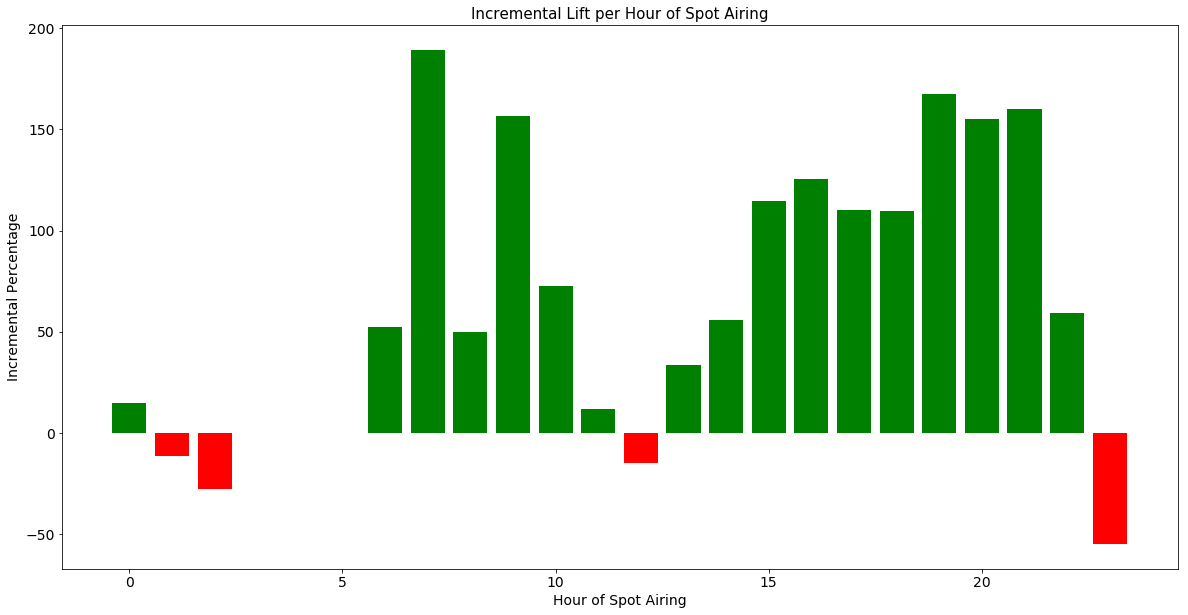

In [57]:
# plot incremental lift per hour of spot airing
final['positive'] = final['inc%'] > 0

plt.figure(figsize=(20,10))
plt.bar(final['spot_hour'],final['inc%'], 
        color=final.positive.map({True: 'g', False: 'r'}))
plt.title("Incremental Lift per Hour of Spot Airing",fontsize=15)
plt.xlabel("Hour of Spot Airing", fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Incremental Percentage", fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(loc=2,title='Increment Type', fontsize=14,labels=final.positive.map({True: 'Increment', False: 'No Incremenent'}))
plt.show()

## 4.5 Incremental Percentage Lift per Network

In [58]:
# check if response type is Drag
avg=q[q.response_type=='Drag'].reset_index(drop=True)
# pivot table
avg=avg.pivot_table(index='network_code', values='visits',
                    aggfunc=sum).reset_index().rename(columns={'visits':'Base_Visits'})
avg.head()

,network_code,Base_Visits
0,COM,4816.0
1,DISH: ESPN,1833.0
2,DISH: NFLN,459.0
3,FS1,914.0
4,FUSE,12198.0


In [59]:
# check if response type is Immediate
inc=q[q.response_type=='Immediate'].reset_index(drop=True)
# pivot table
inc=inc.pivot_table(index='network_code', values='visits',
                    aggfunc=sum).reset_index().rename(columns={'visits':'Immediate_Visits'})
inc.head()

,network_code,Immediate_Visits
0,COM,553.0
1,DISH: ESPN,975.0
2,DISH: NFLN,308.0
3,FS1,1362.0
4,FUSE,3802.0


In [60]:
# pivot table
ads=q.pivot_table(index='network_code', values='id',
                  aggfunc=pd.Series.nunique).reset_index().rename(columns={'id':'Spots_Aired'})
ads.head()

,network_code,Spots_Aired
0,COM,10
1,DISH: ESPN,9
2,DISH: NFLN,6
3,FS1,8
4,FUSE,31


In [61]:
# merge the three tables on the key 'network_code'
final=pd.merge(avg, ads, on=['network_code'])
final=pd.merge(final, inc, on=['network_code'])

# Visits per 10 min to compare against TV Ads immediate incremental visits
final['Base_Visits']=np.ceil(final['Base_Visits']/6)
# create new field for incremental lift percentage
final['inc%']=round(((final['Immediate_Visits']-final['Base_Visits'])/final['Base_Visits'])*100,2)
final.head()

,network_code,Base_Visits,Spots_Aired,Immediate_Visits,inc%
0,COM,803.0,10,553.0,-31.13
1,DISH: ESPN,306.0,9,975.0,218.63
2,DISH: NFLN,77.0,6,308.0,300.00
3,FS1,153.0,8,1362.0,790.20
4,FUSE,2033.0,31,3802.0,87.01


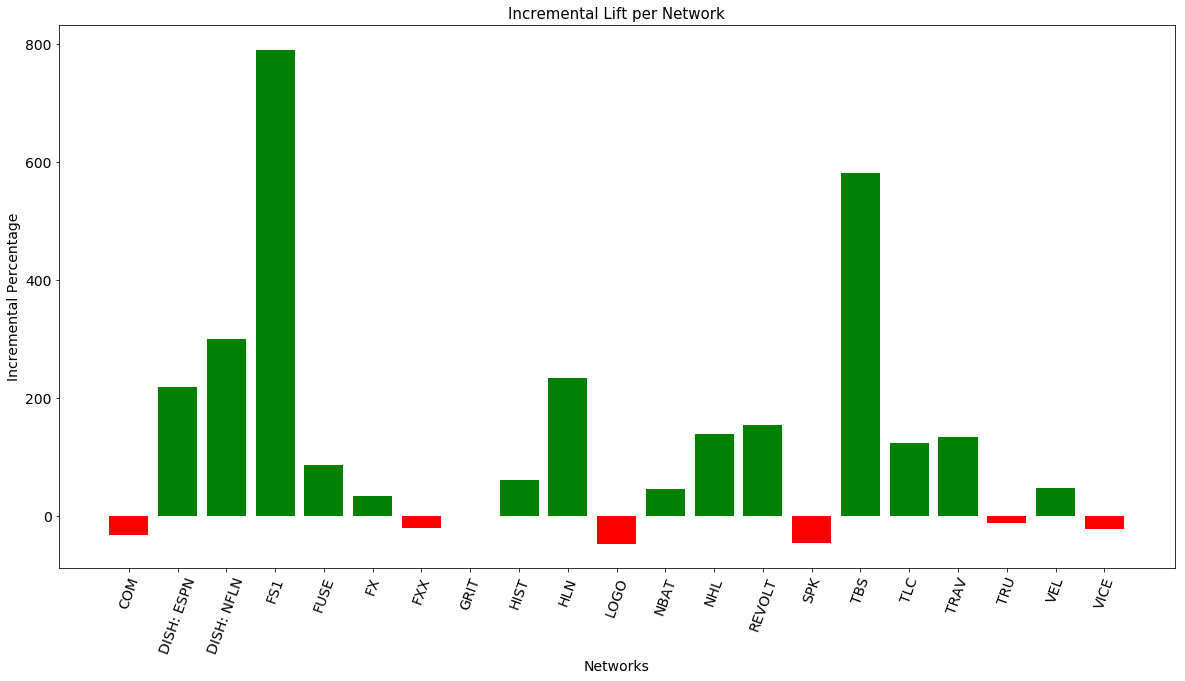

In [62]:
# plot of incremental lift % per Network
final['positive'] = final['inc%'] > 0

plt.figure(figsize=(20,10))
plt.bar(final['network_code'],final['inc%'], 
        color=final.positive.map({True: 'g', False: 'r'}))
plt.title("Incremental Lift per Network",fontsize=15)
plt.xlabel("Networks", fontsize=14)
plt.xticks(rotation=70,fontsize=14)
plt.ylabel("Incremental Percentage", fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(loc=2,title='Increment Type', fontsize=14,labels=final.positive.map({True: 'Increment', False: 'No Incremenent'}))
plt.show()

## 4.6 Incremental Percentage Lift per Spot Duration

In [63]:
# check if response type is Drag
avg=q[q.response_type=='Drag'].reset_index(drop=True)
# pivot table
avg=avg.pivot_table(index='duration', values='visits',
                    aggfunc=sum).reset_index().rename(columns={'visits':'Base_Visits'})
avg.head()

,duration,Base_Visits
0,12.0,2948.0
1,13.0,65127.0
2,14.0,243193.0
3,15.0,7032.0
4,17.0,467.0


In [64]:
# check if response type is Immediate
inc=q[q.response_type=='Immediate'].reset_index(drop=True)
# pivot table
inc=inc.pivot_table(index='duration', values='visits',
                    aggfunc=sum).reset_index().rename(columns={'visits':'Immediate_Visits'})
inc.head()

,duration,Immediate_Visits
0,12.0,1247.0
1,13.0,8856.0
2,14.0,50693.0
3,15.0,1951.0
4,17.0,158.0


In [65]:
# pivot table
ads=q.pivot_table(index='duration', values='id',
                  aggfunc=pd.Series.nunique).reset_index().rename(columns={'id':'Spots_Aired'})
ads.head()

,duration,Spots_Aired
0,12.0,4
1,13.0,89
2,14.0,431
3,15.0,11
4,17.0,4


In [66]:
# merge the dataframes on the key 'duration'
final=pd.merge(avg, ads, on=['duration'])
final=pd.merge(final, inc, on=['duration'])

# Visits per 10 min to compare against TV Ads immediate incremental visits
final['Base_Visits']=np.ceil(final['Base_Visits']/6)
# create a new field for incremental lift %
final['inc%']=round(((final['Immediate_Visits']-final['Base_Visits'])/final['Base_Visits'])*100,2)
final.head()

,duration,Base_Visits,Spots_Aired,Immediate_Visits,inc%
0,12.0,492.0,4,1247.0,153.46
1,13.0,10855.0,89,8856.0,-18.42
2,14.0,40533.0,431,50693.0,25.07
3,15.0,1172.0,11,1951.0,66.47
4,17.0,78.0,4,158.0,102.56


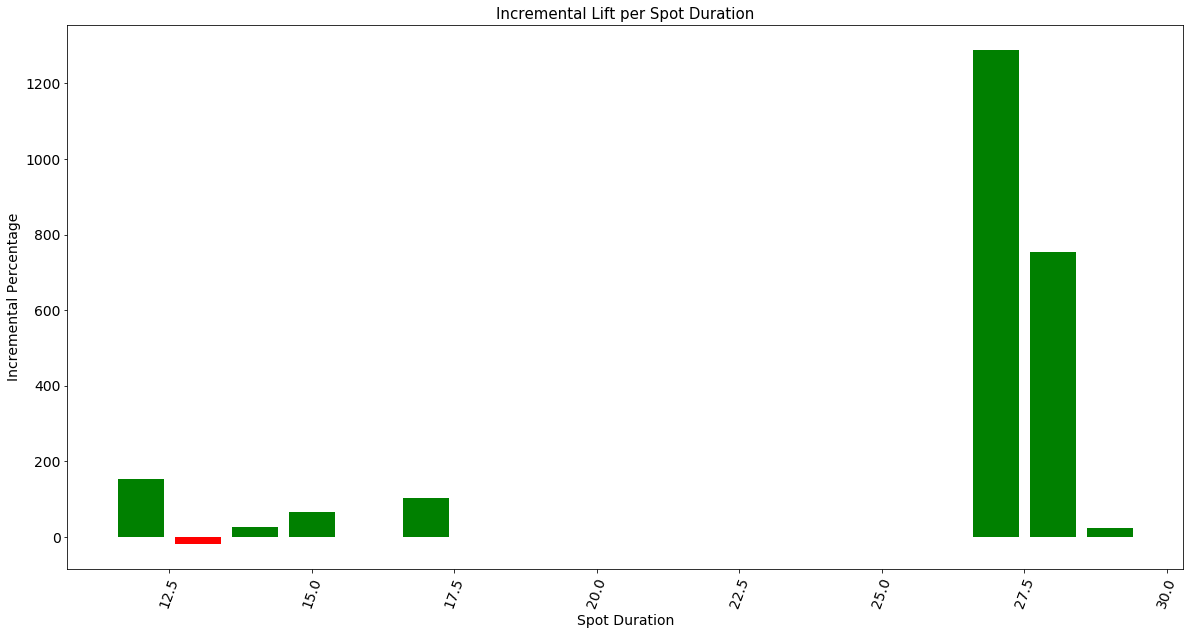

In [67]:
# plot incremental lift percentage per spot duration
final['positive'] = final['inc%'] > 0

plt.figure(figsize=(20,10))
plt.bar(final['duration'],final['inc%'], 
        color=final.positive.map({True: 'g', False: 'r'}))
plt.title("Incremental Lift per Spot Duration",fontsize=15)
plt.xlabel("Spot Duration", fontsize=14)
plt.xticks(rotation=70,fontsize=14)
plt.ylabel("Incremental Percentage", fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(loc=2,title='Increment Type', fontsize=14,labels=final.positive.map({True: 'Increment', False: 'No Incremenent'}))
plt.show()

## 4.7 Incremental Percentage Lift per Rotation

In [68]:
# check if response type is Drag
avg=q[q.response_type=='Drag'].reset_index(drop=True)
# pivot table
avg=avg.pivot_table(index='rotation', values='visits',
                    aggfunc=sum).reset_index().rename(columns={'visits':'Base_Visits'})
avg.head()

,rotation,Base_Visits
0,Everyday Day,12852.0
1,Everyday Early Fringe,24355.0
2,Everyday Late,13502.0
3,Everyday Late Fringe,13381.0
4,Everyday Late Prime,50180.0


In [69]:
# check if response type is Immediate
inc=q[q.response_type=='Immediate'].reset_index(drop=True)
# pivot table
inc=inc.pivot_table(index='rotation', values='visits',
                    aggfunc=sum).reset_index().rename(columns={'visits':'Immediate_Visits'})
inc.head()

,rotation,Immediate_Visits
0,Everyday Day,4319.0
1,Everyday Early Fringe,10473.0
2,Everyday Late,913.0
3,Everyday Late Fringe,4790.0
4,Everyday Late Prime,4075.0


In [70]:
# pivot table
ads=q.pivot_table(index='rotation', values='id',
                  aggfunc=pd.Series.nunique).reset_index().rename(columns={'id':'Spots_Aired'})
ads.head()

,rotation,Spots_Aired
0,Everyday Day,53
1,Everyday Early Fringe,64
2,Everyday Late,10
3,Everyday Late Fringe,8
4,Everyday Late Prime,14


In [71]:
# merge the dataframes on the key 'rotation'
final=pd.merge(avg, ads, on=['rotation'])
final=pd.merge(final, inc, on=['rotation'])

# Visits per 10 min to compare against TV Ads immediate incremental visits
final['Base_Visits']=np.ceil(final['Base_Visits']/6)
final['inc%']=round(((final['Immediate_Visits']-final['Base_Visits'])/final['Base_Visits'])*100,2)
final.head()

,rotation,Base_Visits,Spots_Aired,Immediate_Visits,inc%
0,Everyday Day,2142.0,53,4319.0,101.63
1,Everyday Early Fringe,4060.0,64,10473.0,157.96
2,Everyday Late,2251.0,10,913.0,-59.44
3,Everyday Late Fringe,2231.0,8,4790.0,114.70
4,Everyday Late Prime,8364.0,14,4075.0,-51.28


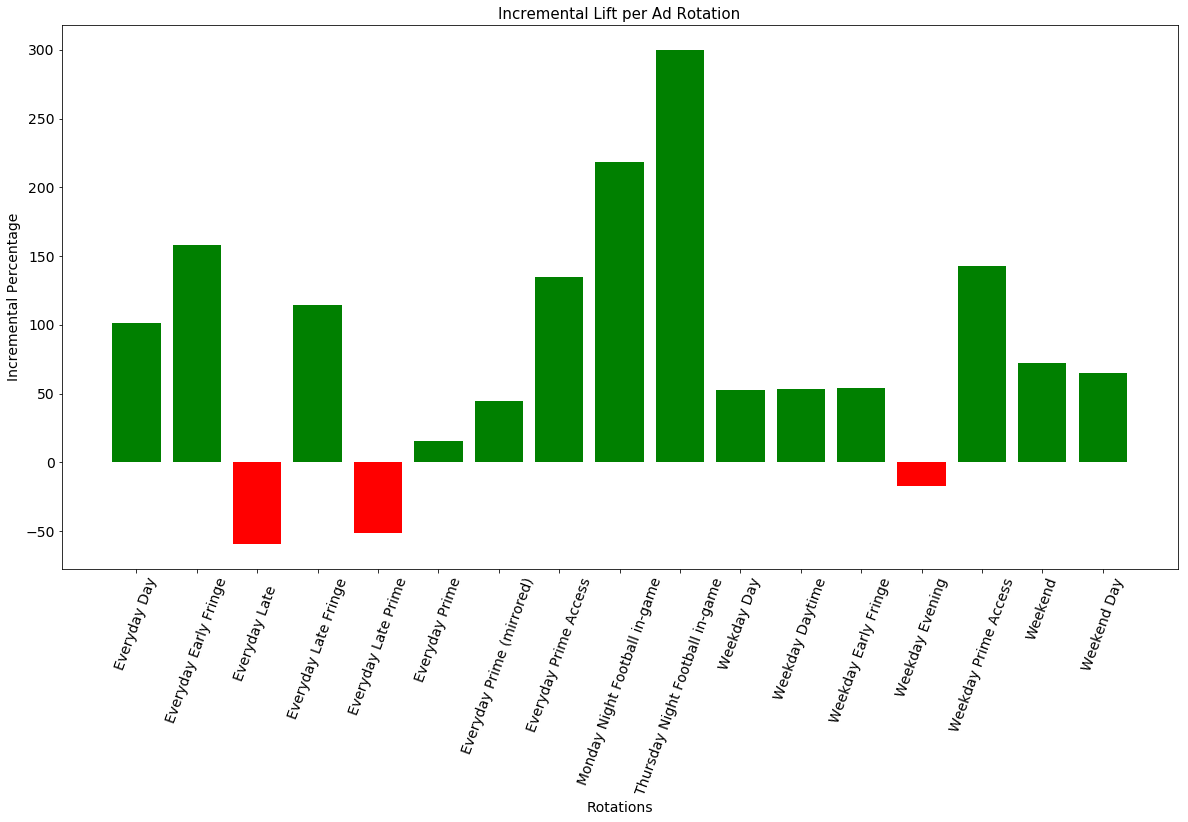

In [72]:
# plot the incremental lift percentage per Ad Rotation
final['positive'] = final['inc%'] > 0

plt.figure(figsize=(20,10))
plt.bar(final['rotation'],final['inc%'], 
        color=final.positive.map({True: 'g', False: 'r'}))
plt.title("Incremental Lift per Ad Rotation",fontsize=15)
plt.xlabel("Rotations", fontsize=14)
plt.xticks(rotation=70,fontsize=14)
plt.ylabel("Incremental Percentage", fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(loc=2,title='Increment Type', fontsize=14,labels=final.positive.map({True: 'Increment', False: 'No Incremenent'}))
plt.show()

In [73]:
# See what networks air spots during the Evening hours
loss=q[q.rotation.str.contains('Evening')].reset_index(drop=True)
loss.network_code.unique()

array(['TRU'], dtype=object)

In [74]:
# See what networks air spots during the Late hours
loss=q[q.rotation.str.contains('Late')].reset_index(drop=True)
loss.network_code.unique()

array(['FXX', 'VICE', 'TLC'], dtype=object)